In [27]:
# generate a Gauss distribution for clustering
# mapping output of qNetwork to some distribution (measurement of probability)

# Oh I need to read GAN, even try some diffusion tricks.
# Target: make a Q-network to output a specific distribution? Why not Hamiltionian? 

# 1. make a bunch of data
# 2. build a Q-network
# 3. train the Q-network to output the distribution of the data using GAN
# 4. test the Q-network

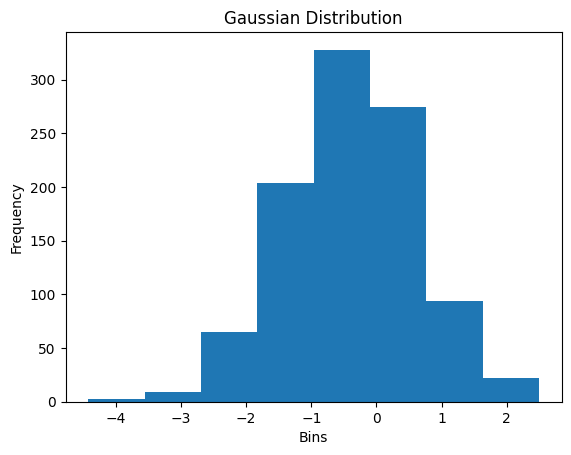

[  3   9  65 204 328 275  94  22]


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# generation of data

# Generate data
data = np.random.normal(loc=0, scale=1, size=1000)

# Create histogram
hist, bins = np.histogram(data, bins=8)

# Plot histogram
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]))
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution')
plt.show()
print(hist)

/opt/homebrew/Caskroom/miniconda/base/envs/qiskit/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


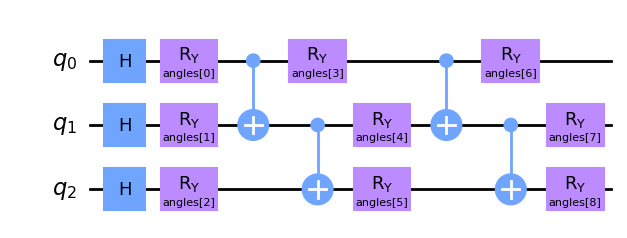

In [29]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter

qr = QuantumRegister(3, 'q')
qc = QuantumCircuit(qr)

# inputs = ParameterVector('inputs', 3)
angles = ParameterVector('angles', 9)

# qc.initialize(inputs[0], 0)

# qc.ry(inputs[0], qr[0])
# qc.ry(inputs[1], qr[1])
# qc.ry(inputs[2], qr[2])

# Layer 0
qc.h(qr[0:3])
qc.ry(angles[0], qr[0])
qc.ry(angles[1], qr[1])
qc.ry(angles[2], qr[2])

# Layer 1

qc.cx(qr[0], qr[1])
qc.ry(angles[3], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[4], qr[1])
qc.ry(angles[5], qr[2])

# Layer 2
qc.cx(qr[0], qr[1])
qc.ry(angles[6], qr[0])
qc.cx(qr[1], qr[2])
qc.ry(angles[7], qr[1])
qc.ry(angles[8], qr[2])

# bind the parameters
# qc = qc.bind_parameters({
#   angles[0]: 0.5, angles[1]: 0.5, angles[2]: 0.5, angles[3]: 0.5, angles[4]: 0.5, angles[5]: 0.5, angles[6]: 0.5, angles[7]: 0.5, angles[8]: 0.5})

# qc.measure_all()

qc.draw('mpl')

In [30]:
# # generate the probability distribution
# from qiskit.visualization import plot_histogram
# from qiskit_aer import AerSimulator
# aersim = AerSimulator()
# result_ideal = aersim.run(qc).result()
# counts_ideal = result_ideal.get_counts(0)
# print('Counts(ideal):', counts_ideal)
# # result = job.result()
# # counts = result.get_counts()
# plot_histogram(counts_ideal)

In [31]:
# build a GAN discriminator
import torch
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x


# pytorch QNN
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector


# qnn = SamplerQNN(circuit=qc, input_params=[], weight_params=angles)
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)


generator = create_generator()
discriminator = Discriminator(8)


# def adversarial_loss(input, target, w):
#     bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
#     weighted_loss = w * bce_loss
#     total_loss = -torch.sum(weighted_loss)
#     return total_loss

criterion = nn.BCELoss()


from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

# qnn.num_weights, qnn.num_inputs
# sampler_qnn_input = algorithm_globals.random.random(qnn.num_inputs)
# sampler_qnn_weights = algorithm_globals.random.random(qnn.num_weights)

# sampler_qnn_input, sampler_qnn_weights

# result = qnn.forward([[]], sampler_qnn_weights)
# print(result)

In [32]:
import time
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/qGAN')

n_epochs = 5000

num_qnn_outputs = 8

# generator_loss_values = []
# discriminator_loss_values = []
# entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    # update D network: maximize log(D(x)) + log(1 - D(G(z)))

    ## train with real
    discriminator_optimizer.zero_grad()
    real_dist = torch.tensor(hist, dtype=torch.float)
    # print(real_dist,discriminator(real_dist))
    real_loss = criterion(discriminator(real_dist), torch.ones(1))
    real_loss.backward()

    ## train with fake
    gen_dist = generator(torch.tensor([]))
    # print(gen_dist,discriminator(gen_dist))
    fake_loss = criterion(discriminator(gen_dist.detach()), torch.zeros(1))
    fake_loss.backward()

    discriminator_optimizer.step()

    writer.add_scalar('DLoss', real_loss + fake_loss, epoch)


    # update G network: maximize log(D(G(z)))
    generator_optimizer.zero_grad()
    gen_dist = generator(torch.tensor([]))
    # print(gen_dist,discriminator(gen_dist))
    generator_loss = criterion(discriminator(gen_dist), torch.ones(1))
    generator_loss.backward()
    generator_optimizer.step()

    writer.add_scalar('GLoss', generator_loss, epoch)


elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

KeyboardInterrupt: 

In [ ]:
# Why we design the circuit in this way?

# superposition + parameter ?

# How to back propagate the parameter?

# How to use the quantum feature to detect the minimum of the function?

# 哥德尔编码